In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bitcoin").getOrCreate()
df = spark.read.csv("btc17-21.csv", header = 'true')
df.show()

+---+----------+-------------+-------------+--------+---------+-----+---------+-------------+------+------+-------+-------+-------+-------+------------------+----------+
|_c0|      time|        nBits|        value|in_count|out_count|count|value_min|    value_max|in_min|in_max|out_min|out_max|   Open|  Close|        Volume BTC|Volume USD|
+---+----------+-------------+-------------+--------+---------+-----+---------+-------------+------+------+-------+-------+-------+-------+------------------+----------+
|  0|1577754000|8843620987040|5739805858577|   47875|    64824|22834|        0| 319312747405|     1|   341|      1|   6794|7213.03|7241.81|             4.373|  31646.53|
|  1|1577757600|2834265498080|1936618920820|   14717|    25700| 7318|      546|  89520922991|     1|   240|      1|    961|7241.81|7218.15|             4.257|  30736.63|
|  2|1577761200|6125932957520|3151256057563|   29784|    39876|15817|      540|  96207131903|     1|   240|      1|   1187|7218.15|7216.57|           

# 3 Regression Model

## Data Processing

In [ ]:
# Features engineering
from pyspark.sql import functions as F
df = (df
    .withColumn('time', df['time']+0)
    .withColumn('nBits', df['nBits']/df['count'])
    .withColumn('value', df['value']+0)
    .withColumn('in_count', df['in_count']+0)
    .withColumn('out_count', df['out_count']+0)
    .withColumn('count', df['count']+0)
    .withColumn('value_max', df['value_max']+0)
    .withColumn('in_max', df['in_max']+0)
    .withColumn('out_max', df['out_max']+0)
    .withColumn('Open', df['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df['Volume BTC'], 5))
    .withColumn('Close', df['Close']+0)
    )
df = (df
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC| Target|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20579.0|  25298.0|10985.0|   8.950576166E10| 240.0|  185.0|7216.57|     7.914|7223.75|
|1.5777684E9|3.8730056E8|3.237367959322E12| 24148.0|  24417.0|10027.0|           5.

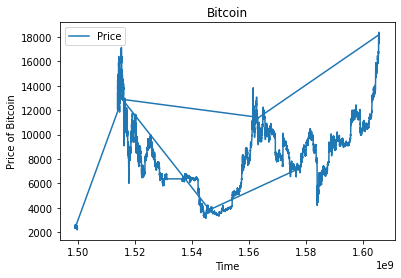

In [ ]:
import matplotlib.pyplot as plt

y = [val.Target for val in df.select('Target').collect()]
x = [val.time for val in df.select('time').collect()]

plt.plot(x, y)

plt.ylabel('Price of Bitcoin')
plt.xlabel('Time')
plt.title('Bitcoin')
plt.legend(['Price'], loc='upper left')

plt.show()

In [ ]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df = assembler.transform(df)
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+--------------------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC| Target|            features|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+--------------------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|[1.577754E9,3.873...|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|[1.5777576E9,3.87...|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|[1.5777612E9,3.87...|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20579.0|  25298.0|10985.0|   8.950576166E10|

In [ ]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
X_train = df.filter(F.col('time') < "1596240000")
X_test = df.filter(F.col('time') > "1596240000")
X_test.show()

+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+--------------------+
|       time|       nBits|            value|in_count|out_count|  count|       value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+--------------------+
|1.5962436E9|3.86970872E8|4.511210992578E12| 36086.0|  42679.0|15023.0|2.69061276955E11| 762.0|  250.0|11268.73|     15.36|11277.84|[1.5962436E9,3.86...|
|1.5962472E9|3.86970872E8| 3.93188978885E12| 53576.0|  39015.0|12141.0|2.18421956191E11|1021.0| 1420.0|11277.84|     18.67|11344.96|[1.5962472E9,3.86...|
|1.5962508E9|3.86970872E8|3.204257837794E12| 16272.0|  29650.0| 7215.0|2.18363458555E11| 660.0| 3443.0|11344.96|     27.89|11372.69|[1.5962508E9,3.86...|
|1.5962544E9|3.86970872E8|2.791870271971E12| 33570.0|  26075.0| 9215.0|2.185

## Linear Regression Model

In [108]:
from pyspark.ml.regression import *
# Applying Linear Regression Model
lr = LinearRegression(featuresCol = 'features', labelCol="Target")
fitted_lr = lr.fit(X_train)
yhat_lr = (fitted_lr.transform(X_test))
yhat_lr = (yhat_lr
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_lr.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+-----------+--------+----------+--------+
|       time|  Target|prediction|Residual|
+-----------+--------+----------+--------+
|1.5962436E9|11277.84|  11270.27|    7.57|
|1.5962472E9|11344.96|  11276.24|   68.72|
|1.5962508E9|11372.69|  11344.28|   28.41|
|1.5962544E9|11401.16|  11371.72|   29.44|
| 1.596258E9|11624.63|  11392.58|  232.05|
|1.5962616E9|11654.12|  11623.64|   30.48|
|1.5962652E9|11671.94|  11653.09|   18.85|
|1.5962688E9|11690.85|  11674.04|   16.81|
|1.5962724E9|11713.76|  11688.96|    24.8|
| 1.596276E9|11629.42|   11716.4|  -86.98|
|1.5962796E9|11662.01|  11629.77|   32.24|
|1.5962832E9|11685.48|  11662.18|    23.3|
|1.5962868E9|11535.66|  11681.55| -145.89|
|1.5962904E9|11618.26|  11537.44|   80.82|
| 1.596294E9|11646.26|  11621.55|   24.71|
|1.5962976E9|11656.39|  11647.81|    8.58|
|1.5963012E9|11746.04|  11656.81|   89.23|
|1.5963048E9|11686.82|  11746.06|  -59.24|
|1.5963084E9| 11801.2|  11687.31|  113.89|
| 1.596312E9| 11852.5|  11802.59|   49.91|
+----------

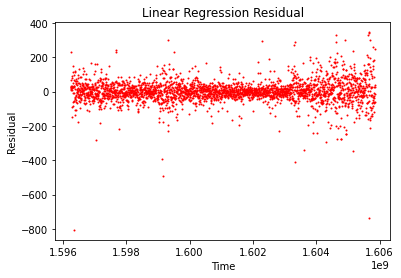

In [109]:
y = [val.Residual for val in yhat_lr.select('Residual').collect()]
x = [val.time for val in yhat_lr.select('time').collect()]

l=plt.plot(x, y, 'ro')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Linear Regression Residual')

plt.show()

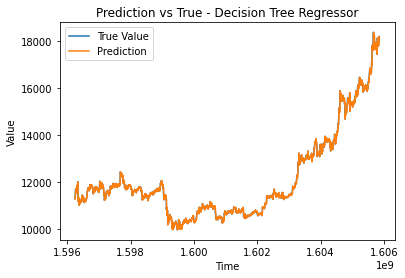

In [110]:
y_predict = [val.prediction for val in yhat_lr.select('prediction').collect()]
y_true = [val.Target for val in yhat_lr.select('Target').collect()]
x = [val.time for val in yhat_lr.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Decision Tree Regressor')
plt.legend()

plt.show()

In [ ]:
# Evaluations of Linear Regression Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_lr)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_lr, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_lr, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 67.13292191831046
MAE is 42.407757532557085
R² is 0.9986910145400684


## Decision Tree Regressor

In [72]:
# Applying Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol="Target")
dt.setSeed(1234567)
fitted_dt = dt.fit(X_train)
yhat_dt = (fitted_dt.transform(X_test))
yhat_dt = (yhat_dt
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_dt.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+-----------+--------+----------+--------+
|       time|  Target|prediction|Residual|
+-----------+--------+----------+--------+
|1.5962436E9|11277.84|   11634.8| -356.96|
|1.5962472E9|11344.96|   11634.8| -289.84|
|1.5962508E9|11372.69|   11634.8| -262.11|
|1.5962544E9|11401.16|   11634.8| -233.64|
| 1.596258E9|11624.63|   11634.8|  -10.17|
|1.5962616E9|11654.12|   11634.8|   19.32|
|1.5962652E9|11671.94|   11634.8|   37.14|
|1.5962688E9|11690.85|   11634.8|   56.05|
|1.5962724E9|11713.76|   11634.8|   78.96|
| 1.596276E9|11629.42|   11634.8|   -5.38|
|1.5962796E9|11662.01|   11634.8|   27.21|
|1.5962832E9|11685.48|   11634.8|   50.68|
|1.5962868E9|11535.66|   11634.8|  -99.14|
|1.5962904E9|11618.26|   11634.8|  -16.54|
| 1.596294E9|11646.26|   11634.8|   11.46|
|1.5962976E9|11656.39|   11634.8|   21.59|
|1.5963012E9|11746.04|   11634.8|  111.24|
|1.5963048E9|11686.82|   11634.8|   52.02|
|1.5963084E9| 11801.2|   11634.8|   166.4|
| 1.596312E9| 11852.5|   11634.8|   217.7|
+----------

No handles with labels found to put in legend.


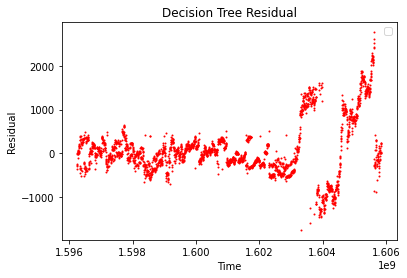

In [96]:
y = [val.Residual for val in yhat_dt.select('Residual').collect()]
x = [val.time for val in yhat_dt.select('time').collect()]

l=plt.plot(x, y, 'ro')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Decision Tree Residual')
plt.legend()

plt.show()

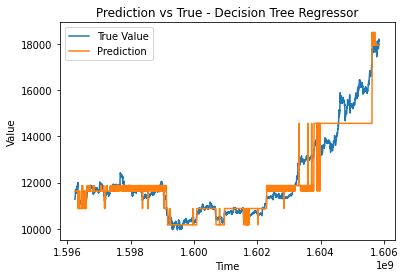

In [102]:
y_predict = [val.prediction for val in yhat_dt.select('prediction').collect()]
y_true = [val.Target for val in yhat_dt.select('Target').collect()]
x = [val.time for val in yhat_dt.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Decision Tree Regressor')
plt.legend()

plt.show()

In [ ]:
# Evaluations of Decision Tree Regressor Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_dt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_dt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_dt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 624.699901858735
MAE is 426.8220540743522
R² is 0.8866538957272594


In [ ]:
# Importance of each features in Decision Tree Regressor
import pandas as pd
score = fitted_dt.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.992056
time,0.007493
nBits,0.000342
value,0.000052
Volume BTC,0.000030
value_max,0.000027
in_count,0.000000
out_count,0.000000
count,0.000000
in_max,0.000000


## Gradient Boosted Tree Regressor

In [75]:
# Applying a gradient boosted tree regressor
gbt = GBTRegressor(labelCol="Target")
gbt.setSeed(1234567)
fitted = gbt.fit(X_train)
yhat_gbt = (fitted.transform(X_test))
yhat_gbt = (yhat_gbt
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_gbt.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+-----------+--------+----------+--------+
|       time|  Target|prediction|Residual|
+-----------+--------+----------+--------+
|1.5962436E9|11277.84|  11447.61| -169.77|
|1.5962472E9|11344.96|   11461.7| -116.74|
|1.5962508E9|11372.69|  11592.69|  -220.0|
|1.5962544E9|11401.16|  11499.16|   -98.0|
| 1.596258E9|11624.63|  11319.16|  305.47|
|1.5962616E9|11654.12|  11486.99|  167.13|
|1.5962652E9|11671.94|  11532.57|  139.37|
|1.5962688E9|11690.85|  11465.01|  225.84|
|1.5962724E9|11713.76|   11472.9|  240.86|
| 1.596276E9|11629.42|  11391.27|  238.15|
|1.5962796E9|11662.01|  11449.35|  212.66|
|1.5962832E9|11685.48|   11472.9|  212.58|
|1.5962868E9|11535.66|  11279.54|  256.12|
|1.5962904E9|11618.26|   11490.3|  127.96|
| 1.596294E9|11646.26|   11578.6|   67.66|
|1.5962976E9|11656.39|  11428.57|  227.82|
|1.5963012E9|11746.04|   11433.3|  312.74|
|1.5963048E9|11686.82|   11433.3|  253.52|
|1.5963084E9| 11801.2|  11428.57|  372.63|
| 1.596312E9| 11852.5|  11428.57|  423.93|
+----------

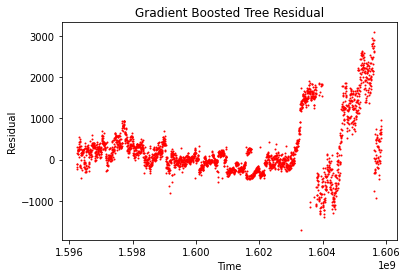

In [103]:
y = [val.Residual for val in yhat_gbt.select('Residual').collect()]
x = [val.time for val in yhat_gbt.select('time').collect()]

l=plt.plot(x, y, 'ro')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Gradient Boosted Tree Residual')

plt.show()

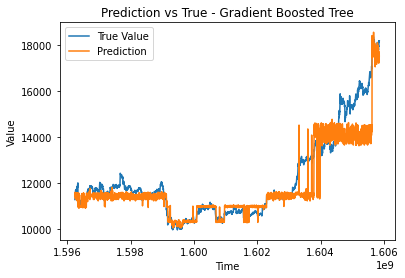

In [100]:
y_predict = [val.prediction for val in yhat_gbt.select('prediction').collect()]
y_true = [val.Target for val in yhat_gbt.select('Target').collect()]
x = [val.time for val in yhat_gbt.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Gradient Boosted Tree')
plt.legend()

plt.show()

In [ ]:
# Evaluations of gradient boosted tree regressor
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_gbt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_gbt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_gbt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 752.8978192840322
MAE is 477.57246338715726
R² is 0.8353598318479118


In [ ]:
# Importance of each features in GBTRegressor
import pandas as pd
score = fitted.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.980530
time,0.006926
Volume BTC,0.002144
value,0.001905
out_max,0.001810
in_count,0.001670
value_max,0.001352
count,0.000989
nBits,0.000960
in_max,0.000858


### Optimise the model with Kfold and GridSearch Method(GBT)

In [ ]:
# Optimise the model with Kfold and GridSearch Method(GBT)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8, 10, 12])
             .addGrid(gbt.maxBins, [32, 64])
             .build())
cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=3)  
cv.setSeed(12345678)
cvModel = cv.fit(X_train)
cvYhat = cvModel.transform(X_test)

cvYhat = (cvYhat
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
cvYhat.select(F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+--------+----------+--------+
|  Target|prediction|Residual|
+--------+----------+--------+
|11277.84|  11183.01|   94.83|
|11344.96|  11183.01|  161.95|
|11372.69|  11191.14|  181.55|
|11401.16|  11396.65|    4.51|
|11624.63|  11413.44|  211.19|
|11654.12|  11413.44|  240.68|
|11671.94|  11430.88|  241.06|
|11690.85|  11447.67|  243.18|
|11713.76|  11413.44|  300.32|
|11629.42|  11440.51|  188.91|
|11662.01|  11447.67|  214.34|
|11685.48|  11413.44|  272.04|
|11535.66|  11413.44|  122.22|
|11618.26|  11447.67|  170.59|
|11646.26|  11427.26|   219.0|
|11656.39|  11454.75|  201.64|
|11746.04|  11447.67|  298.37|
|11686.82|  12004.14| -317.32|
| 11801.2|  11216.31|  584.89|
| 11852.5|  12016.83| -164.33|
+--------+----------+--------+
only showing top 20 rows



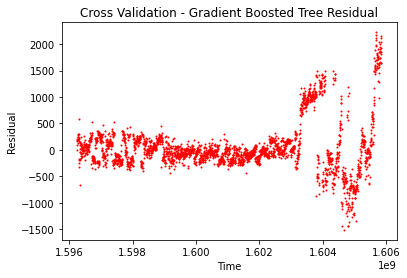

In [104]:
y = [val.Residual for val in cvYhat.select('Residual').collect()]
x = [val.time for val in cvYhat.select('time').collect()]

l=plt.plot(x, y, 'ro')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Cross Validation - Gradient Boosted Tree Residual')

plt.show()

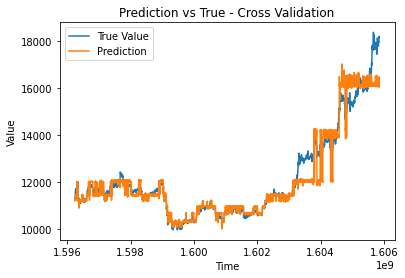

In [105]:
y_predict = [val.prediction for val in cvYhat.select('prediction').collect()]
y_true = [val.Target for val in cvYhat.select('Target').collect()]
x = [val.time for val in cvYhat.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Cross Validation')
plt.legend()

plt.show()

In [ ]:
# Evaluations of Cross Validation
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = eval.evaluate(cvYhat, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(cvYhat, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 480.30093804119525
MAE is 294.97803604956835
R² is 0.9329975640657012


# 3 Classification Model

## Data Processing

In [ ]:
df = (df
       .withColumnRenamed('Target', 'Close')
       .withColumn('Target', F.when(F.col('Close')-F.col('Open') > 0, 1).otherwise(0))
      ) 
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC|  Close|Target|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|     1|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|     0|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|     0|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20579.0|  25298.0|10985.0|   8.950576166E10| 240.0|  185.0|7216.57|     7.914|7223.75|     1|
|1.5777684E9|3.8730056E8|3.2373679

In [ ]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df = assembler.transform(df)
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+------+--------------------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC|  Close|Target|            features|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+------+--------------------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|     1|[1.577754E9,3.873...|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|     0|[1.5777576E9,3.87...|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|     0|[1.5777612E9,3.87...|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20

In [ ]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
X_train = df.filter(F.col('time') < "1596240000")
X_test = df.filter(F.col('time') > "1596240000")
X_test.show()

+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+------+--------------------+
|       time|       nBits|            value|in_count|out_count|  count|       value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|            features|
+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+------+--------------------+
|1.5962436E9|3.86970872E8|4.511210992578E12| 36086.0|  42679.0|15023.0|2.69061276955E11| 762.0|  250.0|11268.73|     15.36|11277.84|     1|[1.5962436E9,3.86...|
|1.5962472E9|3.86970872E8| 3.93188978885E12| 53576.0|  39015.0|12141.0|2.18421956191E11|1021.0| 1420.0|11277.84|     18.67|11344.96|     1|[1.5962472E9,3.86...|
|1.5962508E9|3.86970872E8|3.204257837794E12| 16272.0|  29650.0| 7215.0|2.18363458555E11| 660.0| 3443.0|11344.96|     27.89|11372.69|     1|[1.5962508E9,3.86...|
|1.5962544E9|3.86970872E8|2.791870

## Logistic Regression Model

In [ ]:
from pyspark.ml.classification import *
logr = LogisticRegression(featuresCol = 'features', labelCol='Target', maxIter=2)
fitted_logr = logr.fit(X_train)
yhat_logr = (fitted_logr.transform(X_test))
yhat_logr.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)


+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[-0.0533693584347...|       1.0|[0.48666082639217...|
|     1|[0.03939526700053...|       0.0|[0.50984754317810...|
|     1|[0.16284535391063...|       0.0|[0.54062160908013...|
|     1|[0.06549046735377...|       0.0|[0.51636676749928...|
|     1|[0.01288644883700...|       0.0|[0.50322156762809...|
|     1|[-0.0351379845184...|       1.0|[0.49121640759411...|
|     1|[-0.0244833559195...|       1.0|[0.49387946675539...|
|     1|[-0.0448609574579...|       1.0|[0.48878664115130...|
|     1|[-0.0628434153514...|       1.0|[0.48429431468713...|
|     0|[0.00308919070910...|       0.0|[0.50077229706310...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_logr))

Test Area Under ROC 0.5112090653068556


## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Target', maxDepth = 3)
dtc.setSeed(12345678)
fitted_dtc = dtc.fit(X_train)
yhat_dtc = fitted_dtc.transform(X_test)
yhat_dtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+---------------+----------+--------------------+
|Target|  rawPrediction|prediction|         probability|
+------+---------------+----------+--------------------+
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     1|[3581.0,3350.0]|       0.0|[0.51666426201125...|
|     1|[3581.0,3350.0]|       0.0|[0.51666426201125...|
|     1|[3581.0,3350.0]|       0.0|[0.51666426201125...|
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     1|[8924.0,9588.0]|       1.0|[0.48206568712186...|
|     0|[8924.0,9588.0]|       1.0|[0.48206568712186...|
+------+---------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_dtc))

Test Area Under ROC 0.5106405632039908


## Gradient Boosted Tree Classifier

In [ ]:
# Applying a gradient boosted tree Classifier
gbtc = GBTClassifier(labelCol="Target")
gbtc.setSeed(12345678)
fitted = gbtc.fit(X_train)
yhat_gbtc = (fitted.transform(X_test))
yhat_gbtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[0.01868322235279...|       0.0|[0.50934052439183...|
|     1|[0.07851800416838...|       0.0|[0.53917852228737...|
|     1|[0.02568808402454...|       0.0|[0.51284121759231...|
|     1|[-0.0240051447437...|       1.0|[0.48799973257883...|
|     1|[0.08022781315435...|       0.0|[0.54002806316955...|
|     1|[0.04284247583199...|       0.0|[0.52140814146279...|
|     1|[0.02027843051038...|       0.0|[0.51013782568548...|
|     1|[-0.0027789972524...|       1.0|[0.49861050495070...|
|     1|[0.07945839884399...|       0.0|[0.53964579812544...|
|     0|[-0.0658714802456...|       1.0|[0.46711181397168...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_gbtc))

Test Area Under ROC 0.5197795239832766


### Optimise the model with Kfold and GridSearch Method(GBT)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbtc.maxDepth, [2, 4, 6])
             .addGrid(gbtc.maxBins, [20, 60])
             .addGrid(gbtc.maxIter, [10, 20])
             .build())
cvc = CrossValidator(estimator=gbtc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvc.setSeed(12345678)
cvcModel = cvc.fit(X_train)
yhat_cvc = cvcModel.transform(X_test)
yhat_cvc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     1|[0.04259102376146...|       0.0|[0.52128264456429...|
|     1|[0.04259102376146...|       0.0|[0.52128264456429...|
|     1|[0.04259102376146...|       0.0|[0.52128264456429...|
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     1|[-0.0255228744690...|       1.0|[0.48724133304987...|
|     0|[-0.0517171653971...|       1.0|[0.47416444701340...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_cvc))

Test Area Under ROC 0.5099692619131269
